In [1]:
import os
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# The goal of this notebook
1. Understanding competition
2. Understanding data
3. Understanding Evaluation

# 1. The goal of Competition

Goal: Build a model that forecasts an investment's return rate

# 2. Data

In [2]:
# Using Low mem and fast data
df = pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet')

### Data information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


In [4]:
df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [5]:
print('each column info')

print('row_id: unique row id')
print('time_id: The ID code for the time the data was gathered.')
print('investment_id: investment id')
print('target: target feature')
print('f_0 ~ f_299: 300 of feature')

each column info
row_id: unique row id
time_id: The ID code for the time the data was gathered.
investment_id: investment id
target: target feature
f_0 ~ f_299: 300 of feature


In [6]:
# row_id
# row_id: "row_id" + "_" + "investment_id" !!
print(f"Length of unique row_id: {len(df['row_id'].unique())}")
print(f"start: {list(df['row_id'])[0]}, end: {list(df['row_id'])[-1]}")

Length of unique row_id: 3141410
start: 0_1, end: 1219_3773


In [7]:
# time_id
print(f"Length of unique time_id: {len(df['time_id'].unique())}")
print(f"start: {list(df['time_id'])[0]}, end: {list(df['time_id'])[-1]}")

Length of unique time_id: 1211
start: 0, end: 1219


In [8]:
# investment_id
print(f"Length of unique investment_id: {len(df['investment_id'].unique())}")
print(f"start: {list(df['investment_id'])[0]}, end: {list(df['investment_id'])[-1]}")

Length of unique investment_id: 3579
start: 1, end: 3773


In [9]:
check_row_id = df['time_id'].astype(str) + "_" + df['investment_id'].astype(str)

In [10]:
# Check the row_id assumption
if (df['row_id'] == check_row_id).sum() == df.shape[0]:
    print('row_id assumption is True')
else:
    print('row_id assumption is False')

row_id assumption is True


In [11]:
# target info
df['target'].describe()

count    3.141410e+06
mean    -2.109159e-02
std      9.176629e-01
min     -9.419646e+00
25%     -5.004572e-01
50%     -9.717009e-02
75%      3.572908e-01
max      1.203861e+01
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='Count'>

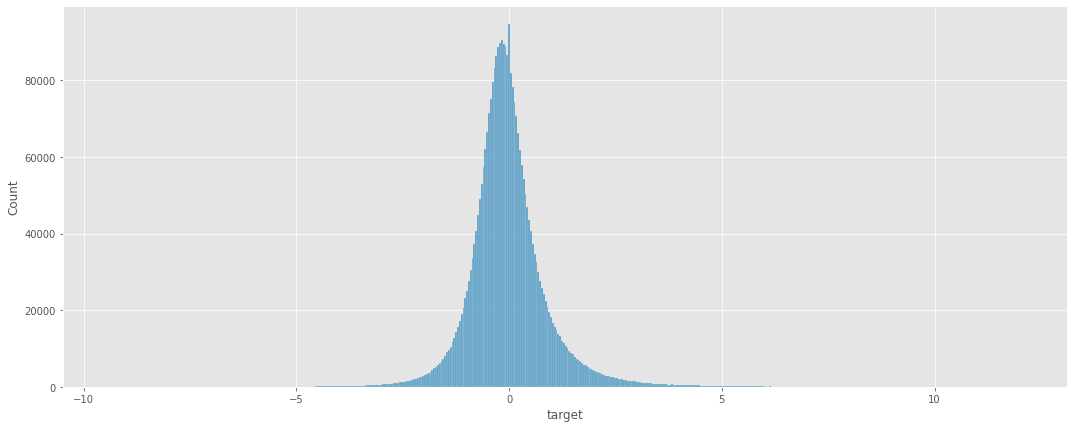

In [12]:
plt.figure(figsize = (18, 7))
sns.histplot(df['target'], bins = 500)

In [13]:
# f_0 ~ f_299 info
feature_df = df.drop(['row_id', 'time_id', 'investment_id', 'target'], axis=1)

In [14]:
feature_df.describe()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,1.637057e-03,-1.257678e-02,8.514749e-03,-2.003703e-02,-5.416438e-03,-3.034008e-03,1.934330e-03,5.898536e-03,1.277584e-02,-3.174983e-03,...,1.256709e-02,9.002053e-04,-6.509154e-03,2.851608e-03,-4.730820e-03,-2.773806e-02,-1.517383e-03,-7.057928e-03,-4.216896e-03,-4.319488e-03
std,1.079721e+00,1.030980e+00,1.030281e+00,9.602916e-01,9.895188e-01,1.104578e+00,1.067755e+00,1.004578e+00,1.073568e+00,1.145388e+00,...,1.084496e+00,1.114387e+00,1.070176e+00,1.101158e+00,1.144516e+00,9.592550e-01,1.140459e+00,1.108097e+00,1.051252e+00,1.008220e+00
min,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,-1.394807e+01,-3.344916e+01,-7.782067e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,-6.300225e-01,1.063952e-01,-8.624281e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,-5.882107e-02,1.590251e-01,1.512278e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,6.883256e-01,2.333343e-01,8.511353e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,5.721995e+00,1.549887e+01,7.320475e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


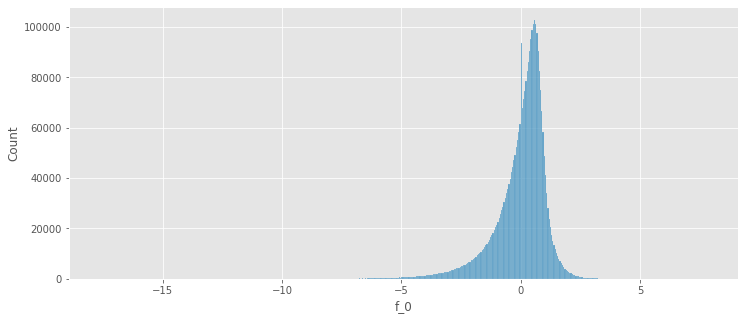

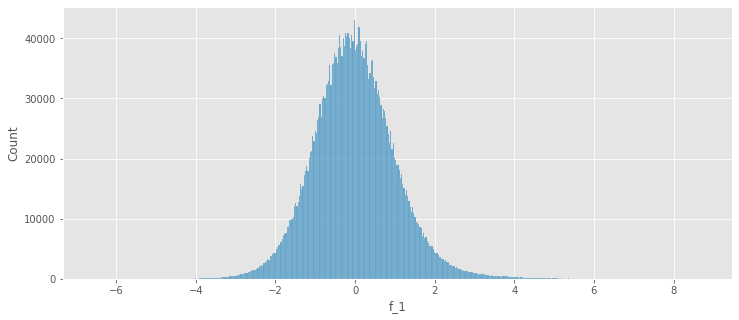

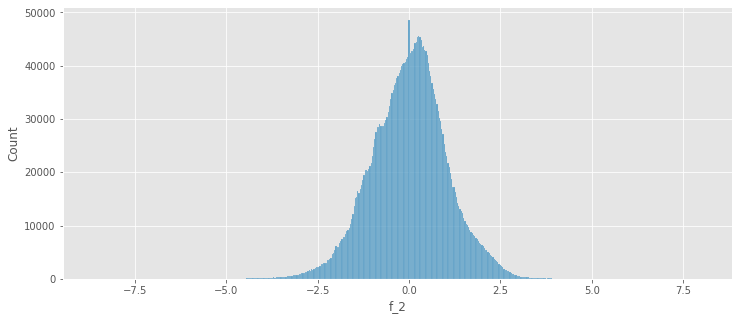

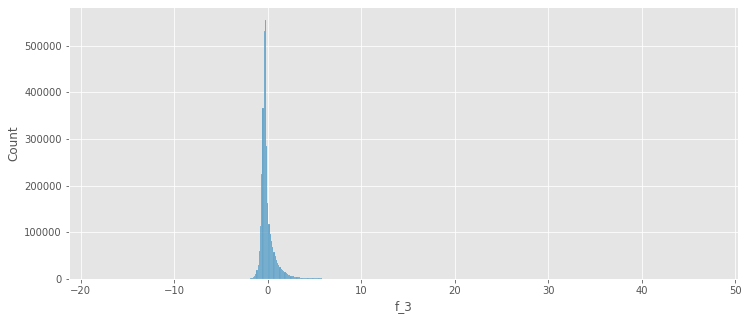

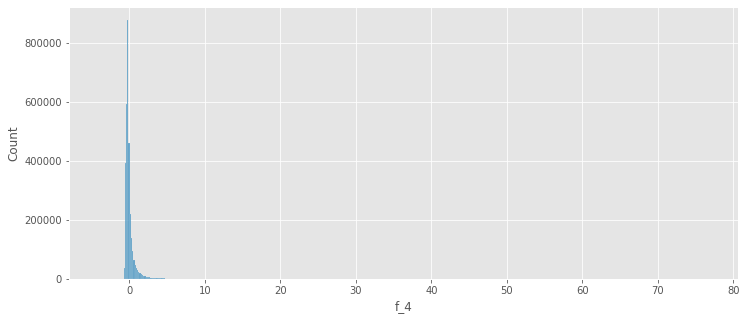

In [15]:
for col in feature_df.columns[:5]:
    plt.figure(figsize = (12, 5))
    sns.histplot(df[col], bins = 500)